In [1]:
import math
import random
import torch # v0.4.1
from torch import nn
from torch.nn import functional as F
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def net(x, params):
    x = F.linear(x, params[0], params[1])
    x1 = F.relu(x)

    x = F.linear(x1, params[2], params[3])
    x2 = F.relu(x)

    y = F.linear(x2, params[4], params[5])

    return y, x2, x1


In [3]:
def adap_net(y, x2, x1, params):
    x = torch.cat([y, x2, x1], dim=1)

    x = F.linear(x, params[0], params[1])
    x = F.relu(x)

    x = F.linear(x, params[2], params[3])
    x = F.relu(x)

    x = F.linear(x, params[4], params[5])

    return x


In [4]:
params = [
    torch.Tensor(32, 1).uniform_(-1., 1.).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]

adap_params = [
    torch.Tensor(32, 1+32+32).uniform_(-1./math.sqrt(65), 1./math.sqrt(65)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(32, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(32).zero_().requires_grad_(),

    torch.Tensor(1, 32).uniform_(-1./math.sqrt(32), 1./math.sqrt(32)).requires_grad_(),
    torch.Tensor(1).zero_().requires_grad_(),
]


In [5]:
opt = torch.optim.SGD(params + adap_params, lr=1e-2)
n_inner_loop = 5
alpha = 3e-2


In [6]:
for it in range(5000):
    b = 0 if random.choice([True, False]) else math.pi

    v_x = torch.rand(4, 1)*4*math.pi - 2*math.pi
    v_y = torch.sin(v_x + b)

    opt.zero_grad()

    new_params = params
    for k in range(n_inner_loop):
        f, f2, f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), new_params)
        h = adap_net(f, f2, f1, adap_params)
        adap_loss = F.l1_loss(h, torch.zeros(1, 1))

        # create_graph=True because computing grads here is part of the forward pass.
        # We want to differentiate through the SGD update steps and get higher order
        # derivatives in the backward pass.
        grads = torch.autograd.grad(adap_loss, new_params, create_graph=True)
        new_params = [(new_params[i] - alpha*grads[i]) for i in range(len(params))]

        if it % 100 == 0: 
            print ('Iteration %d -- Inner loop %d -- Loss: %.4f' % (it, k, adap_loss))

    v_f, _, _ = net(v_x, new_params)
    loss = F.l1_loss(v_f, v_y)
    loss.backward()

    opt.step()

    if it % 100 == 0: 
        print ('Iteration %d -- Outer Loss: %.4f' % (it, loss))


Iteration 0 -- Inner loop 0 -- Loss: 0.0093
Iteration 0 -- Inner loop 1 -- Loss: 0.0081
Iteration 0 -- Inner loop 2 -- Loss: 0.0062
Iteration 0 -- Inner loop 3 -- Loss: 0.0042
Iteration 0 -- Inner loop 4 -- Loss: 0.0066
Iteration 0 -- Outer Loss: 0.5762
Iteration 100 -- Inner loop 0 -- Loss: 0.0521
Iteration 100 -- Inner loop 1 -- Loss: 0.0504
Iteration 100 -- Inner loop 2 -- Loss: 0.0620
Iteration 100 -- Inner loop 3 -- Loss: 0.0439
Iteration 100 -- Inner loop 4 -- Loss: 0.0591
Iteration 100 -- Outer Loss: 0.7912
Iteration 200 -- Inner loop 0 -- Loss: 0.0372
Iteration 200 -- Inner loop 1 -- Loss: 0.0388
Iteration 200 -- Inner loop 2 -- Loss: 0.0532
Iteration 200 -- Inner loop 3 -- Loss: 0.0508
Iteration 200 -- Inner loop 4 -- Loss: 0.0449
Iteration 200 -- Outer Loss: 0.5486
Iteration 300 -- Inner loop 0 -- Loss: 0.0335
Iteration 300 -- Inner loop 1 -- Loss: 0.0585
Iteration 300 -- Inner loop 2 -- Loss: 0.0518
Iteration 300 -- Inner loop 3 -- Loss: 0.0557
Iteration 300 -- Inner loop 4 

Iteration 3100 -- Inner loop 0 -- Loss: 0.3690
Iteration 3100 -- Inner loop 1 -- Loss: 0.1322
Iteration 3100 -- Inner loop 2 -- Loss: 0.0908
Iteration 3100 -- Inner loop 3 -- Loss: 0.1023
Iteration 3100 -- Inner loop 4 -- Loss: 0.0140
Iteration 3100 -- Outer Loss: 0.6088
Iteration 3200 -- Inner loop 0 -- Loss: 0.1434
Iteration 3200 -- Inner loop 1 -- Loss: 0.0860
Iteration 3200 -- Inner loop 2 -- Loss: 0.0937
Iteration 3200 -- Inner loop 3 -- Loss: 0.0225
Iteration 3200 -- Inner loop 4 -- Loss: 0.0330
Iteration 3200 -- Outer Loss: 0.8783
Iteration 3300 -- Inner loop 0 -- Loss: 0.3633
Iteration 3300 -- Inner loop 1 -- Loss: 0.2212
Iteration 3300 -- Inner loop 2 -- Loss: 0.0691
Iteration 3300 -- Inner loop 3 -- Loss: 0.0842
Iteration 3300 -- Inner loop 4 -- Loss: 0.0427
Iteration 3300 -- Outer Loss: 0.7109
Iteration 3400 -- Inner loop 0 -- Loss: 0.2170
Iteration 3400 -- Inner loop 1 -- Loss: 0.1399
Iteration 3400 -- Inner loop 2 -- Loss: 0.0848
Iteration 3400 -- Inner loop 3 -- Loss: 0.0

In [7]:
t_b = math.pi # 0

opt.zero_grad()

t_params = params

In [8]:
for k in range(n_inner_loop):
    t_f, t_f2, t_f1 = net(torch.FloatTensor([[random.uniform(math.pi/4, math.pi/2) if t_b == 0 else random.uniform(-math.pi/2, -math.pi/4)]]), t_params)
    t_h = adap_net(t_f, t_f2, t_f1, adap_params)
    t_adap_loss = F.l1_loss(t_h, torch.zeros(1, 1))

    grads = torch.autograd.grad(t_adap_loss, t_params, create_graph=True)
    t_params = [(t_params[i] - alpha*grads[i]) for i in range(len(params))]

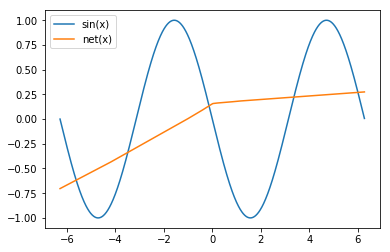

In [9]:
test_x = torch.arange(-2*math.pi, 2*math.pi, step=0.01).unsqueeze(1)
test_y = torch.sin(test_x + t_b)

test_f, _, _ = net(test_x, t_params)

plt.plot(test_x.data.numpy(), test_y.data.numpy(), label='sin(x)')
plt.plot(test_x.data.numpy(), test_f.data.numpy(), label='net(x)')
plt.legend()
plt.savefig('daml-sine.png')